In [1]:
from environment import utils, Environment
from importlib import reload
import matplotlib.pyplot as plt


from absl import flags
FLAGS = flags.FLAGS

import numpy as np

if not FLAGS.find_module_defining_flag('vega_obs', default=None): 
    flags.DEFINE_boolean('vega_obs', True, 'Include portfolio vega and hedging option vega in state variables (Default False)')
# set vega obs to True to include vega in state variables
FLAGS['vega_obs'].value = True
FLAGS.mark_as_parsed()



In [2]:
from importlib import reload
from environment import lmmsabr
reload(lmmsabr)
lmm = lmmsabr.LMMSABR(tenor=4, resolution=26)
lmm.sample_starting_conditions()
lmm.prime()




t_max set to 7
n_curves is none, setting n_curves to n_samples=1
random_curves set to False, using the first n_curves of the dataframe
creating df init for n_curves=1
done creating df_init


/home/hedge/venv/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


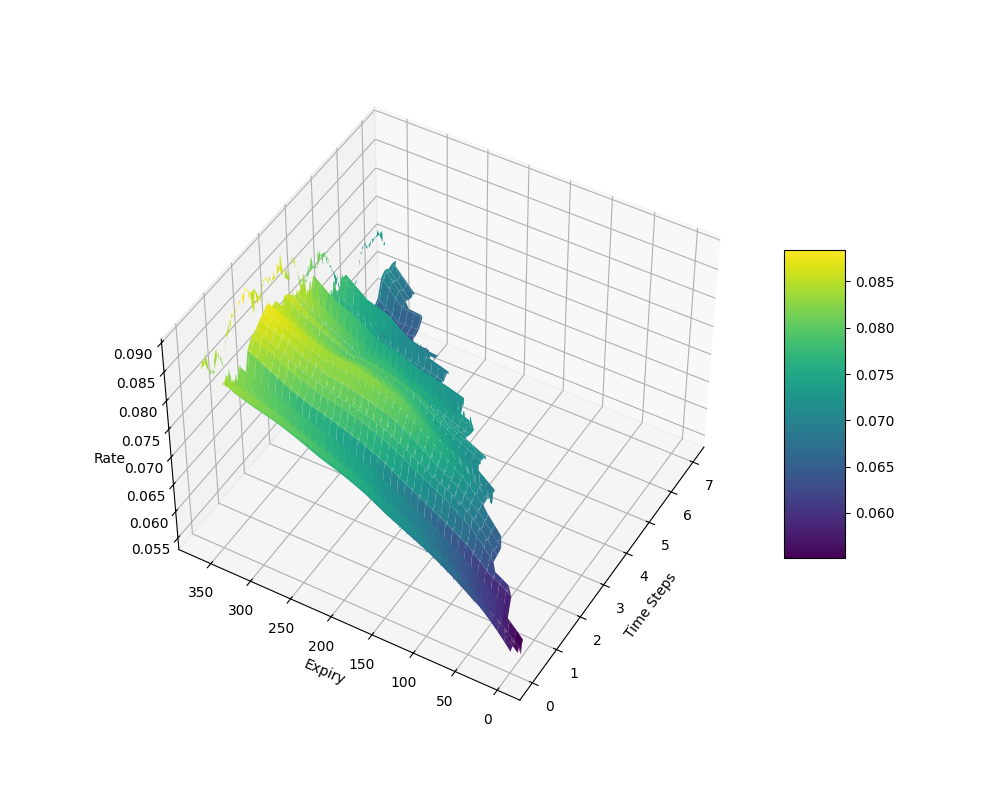

In [13]:
from matplotlib import pyplot as plt
lmm.simulate()
lmm.plot(lmm.f_sim)
plt.show()

In [4]:
np.set_printoptions(precision=10, suppress=True)
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [5]:
reload(utils)
reload(Environment)
util = utils.Utils()

env = Environment.TradingEnv(utils=util)
%load_ext autoreload
%autoreload 2

env.reset()

utils initiated with spread=0, poisson_rate=1, n_episodes=1000

Memory usage before lmm: 1845.02 MB
t_max set to 7
!!!! CONTRACT SIZE IS  100.0
Memory usage after: 1845.02 MB

Memory usage after gc: 1845.02 MB

TRAINING WITH LOGGER: False

initializing classes
done initializing classes
Main portfolio initialized with kernel beta of  1.0  using triangle kernel
REMEMBER TO ADD BACK THE SENSITIVITY FOR LIAB AND HEDGE WHEN USING THE RBF KERNEL


array([34513.094      ,     0.024324851,   214.93123    ,   387.00516    ,   380.57666    ,     0.         ,     1.5908656  ,     1.9754823  ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0.         ,     0. 

In [6]:
env.portfolio.hed_port._base_options[...,Environment.Greek.DELTA]#*1_000_000*0.005

memmap([[2.1493123   , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          ],
        [1.7694404   , 2.1734324   , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0.          , 0

In [7]:
env.portfolio.underlying.active_path_hed[...,Environment.SwapKeys.DELTA]

memmap([[3.8700516, 3.8691356, 3.8682013, 3.867248 , 3.8662758, 3.8652842, 3.864273 , 3.863242 , 3.8621907, 3.861119 , 3.8600268, 3.8589134, 3.857779 , 3.856623 , 3.8554451, 3.8542454, 3.8530233, 3.851779 , 3.8505116, 3.8492215, 3.847908 , 3.8465712, 3.8452108, 3.8438263, 3.842418 , 3.840985 , 3.8395278, 3.8385036, 3.837459 , 3.8363936, 3.8353074, 3.8342   , 3.8330712, 3.831921 , 3.8307495, 3.8295557, 3.8283403, 3.8271024, 3.8258424, 3.8245597, 3.8232543, 3.821926 , 3.820575 , 3.8192008, 3.8178031, 3.8163822, 3.8149376, 3.8134692, 3.811977 , 3.8104608, 3.8089204, 3.8073556],
        [3.8809638, 3.880115 , 3.8792486, 3.878364 , 3.8774614, 3.87654  , 3.8755999, 3.8746405, 3.8736615, 3.8726633, 3.871645 , 3.8706064, 3.8695474, 3.8684678, 3.8673673, 3.8662455, 3.8651023, 3.8639374, 3.8627505, 3.8615417, 3.8603103, 3.8590565, 3.8577797, 3.85648  , 3.8551567, 3.85381  , 3.8524396, 3.8514826, 3.8505056, 3.8495088, 3.8484917, 3.847454 , 3.846396 , 3.8453171, 3.8442173, 3.8430965, 3.8419545, 3.

In [8]:
import tensorflow as tf
S = tf.expand_dims(tf.stack([[1.,2.],[1.,1.]]),axis=0)
#print(S)
d = tf.expand_dims(tf.stack([[1.],[2.]]),axis=0)
#print(d)
weights = tf.unstack(tf.linalg.solve(S,d), axis=-1)
print(weights)

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 3., -1.]], dtype=float32)>]


In [9]:
from agent.agent import KernelLayer


delta_vec = env.portfolio.get_delta_vec(env.t)[None,:]
delta_vec2 = env.portfolio.get_delta_vec(env.t)[None,:]
#delta_vec = np.arange(10)[None,:]
#delta_vec2 = np.arange(105)[None,:]
delta_block_np = np.column_stack([np.concatenate([delta_vec, delta_vec2]), np.ones(2).reshape(-1,1)])
delta_block = tf.convert_to_tensor(delta_block_np, dtype=tf.float32)
vol_kernel = KernelLayer()
vol_kernel(delta_block)

/home/hedge/venv/lib/python3.9/site-packages/sonnet/src/types.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  BoolLike = Union[bool, np.bool, TensorLike]
2025-04-28 10:54:10.797821: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at xla_ops.cc:248 : NOT_FOUND: could not find registered platform with id: 0x7f2437987c14


NotFoundError: could not find registered platform with id: 0x7f2437987c14 [Op:__inference___call___214]

In [ ]:

#print(env.t)
#env.step([0,1])[2]
env.portfolio.get_gamma(env.t)
env.portfolio.get_gamma_local_hed(env.t)
env.portfolio.get_vega

<bound method MainPortfolio.get_vega of <environment.Trading.MainPortfolio object at 0x7faa6af2e430>>

In [ ]:
tau_vals = np.arange(0, 2 + 1e-3, 1/52).astype(np.float32)
tau_vals.shape

(105,)

In [ ]:
env.portfolio.get_delta_vec(env.t).shape[0]-env.portfolio.get_delta_vec(env.t).shape[0]/2

52.0

/home/hedge/venv/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


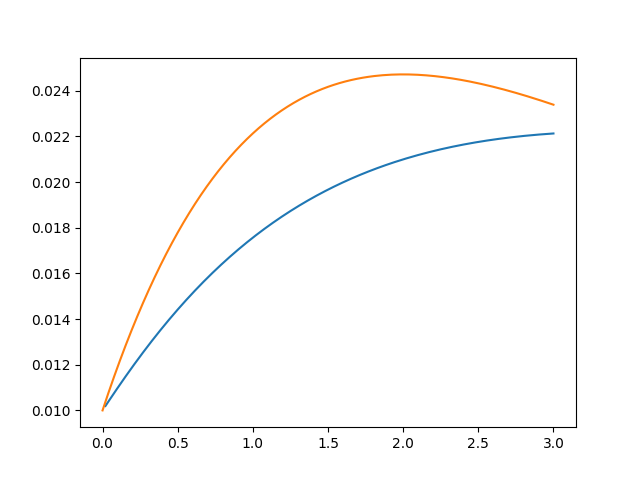

In [ ]:
from functools import partial
def get_instant_vol_func(tau_i , a,b,c,d):

    tau = np.maximum(tau_i, 0)
    instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
    return instantaneous_vol

def doust_corr(tau_i,tau_j, eta, beta):
    return eta + (1-eta) * np.exp(-beta*np.abs(tau_i-tau_j))

def trainable_kernel(tau_i, tau_j, a, b, c, d, eta, beta):
    return doust_corr(eta, beta, tau_i,tau_j) * get_instant_vol_func(tau_j , a,b,c,d) / get_instant_vol_func(tau_i , a,b,c,d)
    


low_bounds = {'a': 0.00, 'b': 0.02, 'c': 0.5, 'd': 0.01}

ts = np.linspace(0,3,105+52) # 3 yers
#np.trapz()
T = ts[-1]
tau = T - ts
vols = get_instant_vol_func(ts,**low_bounds)
delta_kernel =  vols#[:,None]#/vols[52] # normalized to 1y marklt.plot(ts, )
# 3) instantaneous vols as function of tau
vol_tau = get_instant_vol_func(tau, **low_bounds)

# 4) square them
sq = vol_tau**2

# 5) for each index i, integrate σ^2 over [t_i, T] by integrating sq[i:] against ts[i:]
tail_vars = np.array([
    np.trapz(sq[i:], ts[i:])
    for i in range(len(ts)-1)   # we stop at i=len(ts)-2 to avoid dividing by zero
])

# 6) annualise forward vol on [t_i, T]:
#     forward_vol[i] = sqrt( ∫ₜᵢᵀ σ²(u) du  /  (T−t_i) )
forward_vol = np.sqrt(tail_vars / tau[:-1])

# 7) plot it **against** τ = time‐to‐expiry
plt.clf()
plt.plot(tau[:-1], forward_vol)
plt.plot(ts,delta_kernel)
plt.show()

In [ ]:
ts = np.arange(0,3,1/52) # 3 yers
ts[104]

2.0

In [ ]:
import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_probability as tfp

# Alias for bijectors
tfb = tfp.bijectors

class OneYearKernelLayer(snt.Module):
    """
    Sonnet module acting like a layer: takes a risk vector [T] and returns
    a single exposure scalar. Internally computes trainable kernel weights
    anchored at a fixed tenor (1y at index anchor_index).

    Usage:
        exposure = kernel_layer(risk_vector)

    Parameters a,b,c,d,eta,beta are constrained to (0,1) via Sigmoid bijector.
    """
    def __init__(self,
                 tenor_grid=None,
                 anchor_index=52,
                 init_params=None,
                 a_scale = 0.2,
                 b_scale=0.2,
                 c_scale = 1.5,
                 d_scale=0.5,

                 name=None):
        super().__init__(name=name)
        # Build tenor grid: default 0 to 3 years at 1/52
        if tenor_grid is None:
            tau_vals = np.arange(0, 2+1e-5, 1/52).astype(np.float32)
        else:
            tau_vals = np.array(tenor_grid, dtype=np.float32)
        self.tau_grid = tf.constant(tau_vals, dtype=tf.float32)
        self.anchor_index = anchor_index

        # Initial params in (0,1)
        defaults = init_params or {'a':0.5,'b':0.5,'c':1.,'d':0.001,'eta':0.5,'beta':0.5}
        sigmoid = tfb.Sigmoid()
        # Vol function params
        self.a    = tfp.util.TransformedVariable(defaults['a'],    sigmoid, name='a') * a_scale
        self.b    = tfp.util.TransformedVariable(defaults['b'],    sigmoid, name='b') * b_scale
        self.c    = tfp.util.TransformedVariable(defaults['c'],    sigmoid, name='c') * c_scale
        self.d    = tfp.util.TransformedVariable(defaults['d'],    sigmoid, name='d')*d_scale + 0.001
        # Correlation params
        self.eta  = tfp.util.TransformedVariable(defaults['eta'],  sigmoid, name='eta')*0.95
        self.beta = tfp.util.TransformedVariable(defaults['beta'], sigmoid, name='beta')*0.5

    def _compute_weights(self):
        """
        Compute the kernel weight vector [T]."""
        tau = self.tau_grid                             # [T]
        vols = (self.a + self.b * tau)*tf.exp(-self.c * tau) + self.d  # [T]
        vol_ref = vols[self.anchor_index]                # scalar
        tau_ref = tau[self.anchor_index]                 # scalar
        dist = tf.abs(tau - tau_ref)                     # [T]
        corr = self.eta + (1. - self.eta)*tf.exp(-self.beta * dist)  # [T]
        return corr * (vols / vol_ref)                   # [T]

    def __call__(self, risk_vector):
        """
        Args:
          risk_vector: 1D tensor [T] of risk sensitivities.
        Returns:
          scalar exposure.
        """
        weights = self._compute_weights()                # [T]
        plt.clf()
        plt.plot(weights)
        plt.show()
        return tf.reduce_sum(weights * risk_vector)      # scalar

In [ ]:
layer = OneYearKernelLayer()

In [ ]:
a1 = np.arange(10)[None,:]
a2 = np.arange(10)[None,:]
np.concatenate([a1,a2],axis=0)

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [ ]:
t=52
gv = np.arange(1,3+1e-3,1/52)[:53+t]
gt = np.zeros(105)
gt[52-t:] = gv

print(gt[:,None][52])

[2.]
